# Information Retrieval - Corpus Filtering  
This notebook retrieves abstracts relevant to pandemics and then uses topic modeling to analyze the chosen abstracts.  Two info retrieval techniques are used: Literal Term Matching and Latent Semantic Indexing.  These are linear algebra techniques.  
We use the Scikit-Learn library.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)

import numpy as np
import pickle
import matplotlib.pyplot as plt
import gensim
import time

from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity

#import spacy
#from spacy.lang.en.stop_words import STOP_WORDS

In [2]:
# pull in data

# full corpus
df = pd.read_pickle("../../../../data/prd/Tech-Report/FR_meta_and_final_tokens_21SEPT14.pkl")
df.reset_index(inplace = True)

# pandemics corpus
#df = pd.read_pickle("pandemic_corpus.pkl")
#df.reset_index(inplace = True)
#df.rename(columns={'index':'original index'}, inplace=True)

In [3]:
df.head()

,index,original index,PROJECT_ID,ABSTRACT,FY,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY.y,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,final_tokens
0,0,0,89996,"This is a project to explore Game-based, Metap...",2008,Achievement; analog; base; Cognitive Science; ...,RUI: CYGAMES: CYBER-ENABLED TEACHING AND LEARN...,NSF,NSF,NaN,0814512,9/15/2008,8/31/2012,"REESE, DEBBIE D","CARTER, BEVERLY; WOOD, CHARLES; HITT, BEN",01,068719400,WHEELING JESUIT UNIVERSITY,WHEELING,WV,26003-6243,UNITED STATES,NaN,NaN,47.076,2008,1999467.0,NaN,1,1,"[project, explore, game, base, metaphor, enhan..."
1,1,1,89997,Institution: Franklin Institute Science Museum...,2008,Active Learning; Child; Computer software; des...,ARIEL - AUGMENTED REALITY FOR INTERPRETIVE AND...,NSF,NSF,NaN,0741659,9/15/2008,8/31/2012,"SNYDER, STEVEN","ELINICH, KAREN; YOON, SUSAN",02,001741859,FRANKLIN INSTITUTE,PHILADELPHIA,PA,19103-1115,UNITED STATES,NaN,NaN,47.076,2008,1799699.0,NaN,1,1,"[institution, franklin_institute, science, mus..."
2,2,2,89998,Through programs (including small group conver...,2008,Address; Age; Birth; Brain; Caregivers; Child;...,BRIGHTER FUTURES: PUBLIC DELIBERATION ABOUT TH...,NSF,NSF,NaN,0813522,9/15/2008,8/31/2011,"FINK, LAURIE KLEINBAUM","CADIGAN, KAREN; ELLENBOGEN, KIRSTEN",04,061451670,SCIENCE MUSEUM OF MINNESOTA,SAINT PAUL,MN,55102-1202,UNITED STATES,NaN,NaN,47.076,2008,1505858.0,NaN,1,1,"[program, small, group, conversation, citizen,..."
3,3,3,89999,In partnership with the American Chemical Soci...,2008,Advanced Development; American; Chemicals; Che...,FOSTERING US-INTERNATIONAL COLLABORATIVE PARTN...,NSF,NSF,NaN,0838627,8/1/2008,12/31/2010,"JOST, JOHN W","MILLER, BRADLEY; BOWMAN, KATHERINE",04,009059242,INTERNATIONAL UNION OF PURE AND APPLIED CHEMISTRY,DURHAM,NC,27709-3757,UNITED STATES,NaN,NaN,47.049,2008,51000.0,NaN,1,1,"[partnership, american, chemical, society, acs..."
4,4,5,90001,The Center for Molecular Interfacing (CMI) wil...,2008,Address; Architecture; Carbon Nanotubes; Catal...,CCI PHASE I: CENTER FOR MOLECULAR INTERFACING,NSF,NSF,NaN,0847926,10/1/2008,9/30/2011,"ABRUNA, HECTOR D",NaN,22,872612445,CORNELL UNIVERSITY ITHACA,ITHACA,NY,14850-2820,UNITED STATES,NaN,NaN,47.049,2008,1519821.0,NaN,1,1,"[center, molecular, interfacing, cmi, enable, ..."


In [4]:
# input needed for doc-term matrix creation in Scikit-Learn is one string per document (not a list of strings).  
# Original data 'ABSTRACT' is already in this form, but not the tokens in "final_frqwds_removed"


tokens = df['final_tokens']   #df["stopwds_removed"]

docs = [] # docs will contain the processed tokens in string form (1 string per abstract)

for abstract in tokens:
    docs.append(" ".join(abstract))
    
docs = pd.Series(docs)


#docs = df["ABSTRACT"]  # raw text


### Term Matching

In [5]:
# new approach to grab all "pandemic" matches

term_match_idx = []

for i, abstract in enumerate(docs):
    if ('pandemic' in abstract): #or ('epidemic' in abstract):
        term_match_idx.append(i)
        

In [6]:
len(term_match_idx) 

2308

### Helper Functions

In [7]:
# Create binary query vector 

def create_query(words, terms):
    
    # words: search query words
    # terms: terms in corpus
    
    q = np.zeros(len(terms))  # number of terms

    idx = []
    for word in query_words:
        idx.append(terms.index(word))

    q[idx] = 1
    
    return q

In [8]:
def return_top_abstracts(scores, top_n):
    
    '''
    docs: Series that contains abstract
    scores: scores of abstracts
    top_n: return the top_n abstracts given by idx, if top_n = -1 return all abstracts
    '''
    # sort scores in descending order
    scores_sorted_idx = np.argsort(scores)[::-1]
    
    if top_n == -1:
        #n = sum(scores > 0)
        ix = scores_sorted_idx #[:n]
    else:
        ix = scores_sorted_idx[:top_n]
    
    #print(ix[0:10])
    
    return ix
    

In [9]:
def create_result_df(abstracts, scores):
    
    df = pd.DataFrame()
    df["abstracts"] = abstracts
    df["scores"] = scores
    
    return df

In [10]:
# Find doc-term matrix using TF-IDF weighting

tf_idf_vectorizer = TfidfVectorizer()
tf_idf = tf_idf_vectorizer.fit_transform(docs)

tf_idf_terms = tf_idf_vectorizer.get_feature_names()

In [11]:
len(tf_idf_terms)

1278210

In [12]:
count = 0

for term in tf_idf_terms:
    if 'pandemic' in term:
        print(term)
        count = count + 1
        
print(count)

1918_influenza_pandemic
1918_pandemic
1957_1968_pandemics
2009_pandemic_h1n1
aidspandemic
andpandemic
andpandemics
apandemic
bothpandemic
causedpandemics
co_pandemic
detetermrminineififththesuprragenomeofftthepandemiciccllonesiis
devastating_pandemics
ebolapandemic
epidemics_occasional_pandemics
epidemics_pandemics
escalatingpandemic
establishingpandemic
flu_pandemic
futurepandemics
globalpandemic
greatpandemic
growingpandemic
h1n1_influenza_pandemic
h1n1_pandemic
h5n1_pandemic
hivpandemic
humanpandemics
increasedpandemic
influenza_pandemics
influenzapandemic
influenzapandemics
inpandemic
inter_pandemic
interpandemic
majorpandemic
non_pandemic
occasional_pandemics
occasionalpandemics
ofpandemic
ofpandemics
pandemic
pandemic57499
pandemic_1918
pandemic_flu
pandemic_h1_n1
pandemic_h1n1
pandemic_h2n2
pandemic_influenza
pandemic_non_pandemic
pandemic_preparedness
pandemically
pandemicand
pandemiccompare
pandemicdisease
pandemicemergence
pandemicflu
pandemichuman
pandemicin
pandemicinfectio

#### Word cloud

In [13]:
# Find doc-term matrix for word cloud

vectorizer = CountVectorizer()
dtm = vectorizer.fit_transform(docs)

terms = vectorizer.get_feature_names()

In [14]:
dtm.shape

(696093, 1278210)

In [15]:
term_counts = dtm.sum(axis=0)

In [16]:
d = {}

for i, term in enumerate(terms):
    if 'pandemic' in term:
        #print(term)
        d[term] = term_counts[0,i]

In [17]:
d

{'1918_influenza_pandemic': 51,
 '1918_pandemic': 68,
 '1957_1968_pandemics': 12,
 '2009_pandemic_h1n1': 54,
 'aidspandemic': 2,
 'andpandemic': 1,
 'andpandemics': 1,
 'apandemic': 2,
 'bothpandemic': 2,
 'causedpandemics': 1,
 'co_pandemic': 1,
 'detetermrminineififththesuprragenomeofftthepandemiciccllonesiis': 1,
 'devastating_pandemics': 26,
 'ebolapandemic': 1,
 'epidemics_occasional_pandemics': 10,
 'epidemics_pandemics': 66,
 'escalatingpandemic': 1,
 'establishingpandemic': 1,
 'flu_pandemic': 26,
 'futurepandemics': 1,
 'globalpandemic': 1,
 'greatpandemic': 1,
 'growingpandemic': 1,
 'h1n1_influenza_pandemic': 13,
 'h1n1_pandemic': 47,
 'h5n1_pandemic': 27,
 'hivpandemic': 8,
 'humanpandemics': 1,
 'increasedpandemic': 1,
 'influenza_pandemics': 72,
 'influenzapandemic': 1,
 'influenzapandemics': 1,
 'inpandemic': 1,
 'inter_pandemic': 5,
 'interpandemic': 7,
 'majorpandemic': 1,
 'non_pandemic': 7,
 'occasional_pandemics': 8,
 'occasionalpandemics': 1,
 'ofpandemic': 3,
 'of

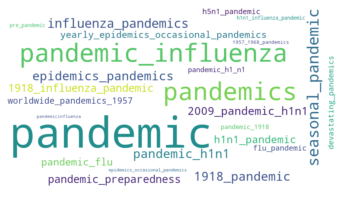

In [18]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=900, height= 500, scale=1, max_words = 25, background_color='white').generate_from_frequencies(d)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("pan_wc.png", dpi = 800, bbox_inches = "tight")
plt.show()

## Latent Semantic Indexing (LSI)

In [13]:
# CHANGE QUERY WORDS HERE

query_words = []

for word in tf_idf_terms:
    if 'pandemic' in word:
        query_words.append(word)

#query_words = ['pandemic', 'pandemics'] 
              
q = create_query(query_words, tf_idf_terms)

In [14]:
query_words

['1918_influenza_pandemic',
 '1918_pandemic',
 '1957_1968_pandemics',
 '2009_pandemic_h1n1',
 'aidspandemic',
 'andpandemic',
 'andpandemics',
 'apandemic',
 'bothpandemic',
 'causedpandemics',
 'co_pandemic',
 'detetermrminineififththesuprragenomeofftthepandemiciccllonesiis',
 'devastating_pandemics',
 'ebolapandemic',
 'epidemics_occasional_pandemics',
 'epidemics_pandemics',
 'escalatingpandemic',
 'establishingpandemic',
 'flu_pandemic',
 'futurepandemics',
 'globalpandemic',
 'greatpandemic',
 'growingpandemic',
 'h1n1_influenza_pandemic',
 'h1n1_pandemic',
 'h5n1_pandemic',
 'hivpandemic',
 'humanpandemics',
 'increasedpandemic',
 'influenza_pandemics',
 'influenzapandemic',
 'influenzapandemics',
 'inpandemic',
 'inter_pandemic',
 'interpandemic',
 'majorpandemic',
 'non_pandemic',
 'occasional_pandemics',
 'occasionalpandemics',
 'ofpandemic',
 'ofpandemics',
 'pandemic',
 'pandemic57499',
 'pandemic_1918',
 'pandemic_flu',
 'pandemic_h1_n1',
 'pandemic_h1n1',
 'pandemic_h2n2',

In [15]:
len(query_words)

82

In [16]:
# Find the Truncated SVD of the TF-IDF matrix

lsa = TruncatedSVD(n_components=50, random_state=1)  # CHANGE THE NUMBER OF COMPONENTS - NOTE: MORE COMPONENTS 
                                                      # GIVES YOU A MORE ACCURATE APPROXIMATION OF THE DOC-TERM 
                                                      # MATRIX, BUT IS ALSO MORE EXPENSIVE AND MAY NOT LEAD TO THE 
                                                      # BEST INFO RETRIEVAL RESULTS.
USigma = lsa.fit_transform(tf_idf)
Vtrans = lsa.components_

In [17]:
S = lsa.singular_values_

In [18]:
S

array([126.2026823 ,  75.50207405,  58.61957317,  53.70609248,
        53.36235746,  48.98076647,  45.11536839,  42.34263352,
        39.78461328,  38.50170746,  37.75460958,  36.86680447,
        35.77699442,  34.187326  ,  33.6845451 ,  33.14176657,
        32.57960967,  31.90029149,  31.330768  ,  31.25763889,
        30.66783579,  30.32479277,  30.04793135,  29.6305617 ,
        29.09908964,  28.83356198,  28.7106275 ,  28.4572269 ,
        28.19216753,  27.92769557,  27.44585017,  27.20000949,
        26.65938306,  26.55558445,  26.18490167,  26.01166586,
        25.82502699,  25.64733363,  25.54309587,  25.39677687,
        25.18133438,  24.98979787,  24.84571794,  24.7454733 ,
        24.56094518,  24.36732609,  24.08132006,  23.84525827,
        23.57788701,  23.49980015])

In [19]:
# transform query to be in same space as documents

q = q.reshape(1,-1)  # changes (n,) vector to (1,n)
qhat = lsa.transform(q)

In [20]:
print(qhat.shape)
print(USigma.shape)
print(Vtrans.shape)

(1, 50)
(696093, 50)
(50, 1278210)


In [21]:
lsa_scores = cosine_similarity(qhat, USigma)  

In [22]:
sum(lsa_scores[0] > 0)

# 10: 447043
# 50: 376366   |  388482
# 100: 378149
# 150: 
# 200: 361772
# 500: 

388482

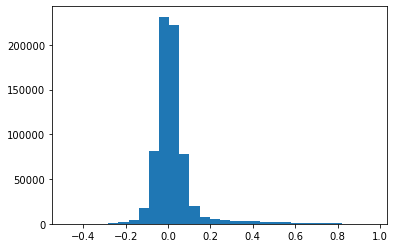

In [23]:
plt.hist(lsa_scores[0], bins = 30);
#plt.xlim(0.9, 1.1)

In [24]:
#np.percentile(lsa_scores[0], 93)

sum(lsa_scores[0] >= 0.5)#/len(lsa_scores[0])

# 10: 37846
# 50: 8454    | 7598
# 100: 3340
# 150: 
# 200: 1458
# 500: 

7598

In [25]:
np.percentile(lsa_scores[0], 99)

0.5147699530707883

In [26]:
2000/len(lsa_scores[0])

0.002873179302190943

In [27]:
lsa_idx = return_top_abstracts(lsa_scores[0], -1)  # CHANGE NUMBER OF TOP DOCS RETURNED -- 2000
top_lsa_abstracts = docs[lsa_idx]

# top scores
lsa_scores[0][lsa_idx][0:10]

array([0.96193369, 0.96065641, 0.94892791, 0.94892791, 0.94723005,
       0.94530215, 0.94461166, 0.94329276, 0.94044104, 0.94044104])

In [28]:
top_lsa_abstracts[0:25]

458334    influenza virus infection cause significant mo...
663850    influenza virus infection cause significant mo...
258602    april 2009 centers disease control prevention ...
329048    april 2009 centers disease control prevention ...
325384    epidemiological success pandemic epidemic infl...
625742    use clinical sample identify influenza virus a...
380216    lid scientist collaborate scientist medimmune_...
477165    ferret widely use influenza virus pathogenesis...
456505    iaa provide funding quantification usa swine i...
549592    iaa provide funding quantification usa swine i...
428232    iaa provide funding quantification usa swine i...
687086    iaa provide funding quantification usa swine i...
586295    iaa provide funding quantification usa swine i...
503734    iaa provide funding quantification usa swine i...
123103    appropriate vaccine essential global pandemic_...
429075    experimental laboratory component use reverse ...
328723    mosquito_bern member family bu

In [29]:
top_lsa_abstracts.iloc[1999]

'objective determine impact variant emerge virus development control respiratory disease ruminant develop means detect survey variant virus develop model evaluate infection emerge variant virus subobjective determine impact variant emerge virus improve current surveillance method diagnostic tool use detect control emerge virus objective elucidate host pathogen interaction associate bovine respiratory disease complex brdc define host pathway modulate result viral infection characterize role stress immunological related host effector molecule brdc_subobjective define interaction viral pathogen contribute development respiratory disease define modulation host immune response viral infection associate stress cause vitamin_d_insufficiency objective evaluate formulation delivery system vaccination neonate identify means modulate stress immunological factor associate brdc generate identification criterion mean generate vaccine ready calve develop intervention strategy control viral respirator

In [30]:
lsa_scores[0][lsa_idx][1990:2000]

array([0.68899447, 0.68899447, 0.68882351, 0.68840109, 0.68836624,
       0.68831429, 0.68826001, 0.68820921, 0.68819917, 0.68817755])

### How do LSI and Term Matching Overlap?

In [34]:
# look at the intersection/difference -- LSI seems to pick up mainly influenza

#temp = list(set(term_match_idx).intersection(set(lsa_idx[0:2000])))
temp = list(set(term_match_idx) - set(lsa_idx[0:2000]))

In [35]:
len(temp)

1839

In [36]:
df['ABSTRACT'].iloc[temp[401]]

'DESCRIPTION (provided by applicant): The emerging obesity pandemic is driving an alarming increase in the prevalence of insulin resistant forms of diabetes. The mechanisms whereby obesity leads to insulin resistance remain to be fully elucidated. Chronic caloric excess leads to increased delivery of adipose-derived fatty acids (FA) and cytokines to insulin responsive tissues such as skeletal muscle and heart, which can result in toxic effects (cellular  lipotoxicity ). Myocyte lipotoxicity is associated with mitochondrial derangements, insulin resistance, glucose intolerance, and striated muscle dysfunction, yet cause-effect relationships have not been established. Moreover, the molecular regulatory pathways that are protective or pathogenic in the cellular lipotoxic response have not been defined. We propose that traditional single disciplinary approaches to this problem cannot effectively address this complex process. Therefore, we plan to establish an interdisciplinary research tea

In [37]:
len(lsa_idx)

696093

In [39]:
# find term matching indices in sorted scores list

tm_in_lsa_idx = []
tm_lsa_score = []

for i in term_match_idx:
    j = list(lsa_idx).index(i)
    tm_in_lsa_idx.append(j)
    tm_lsa_score.append(lsa_scores[0][lsa_idx[j]])        

In [40]:
tm_in_lsa_idx[0:5]

[61011, 67272, 6240, 2205, 523487]

In [41]:
tm_lsa_score[0:5]

[0.09651653357997687,
 0.08997739464500154,
 0.5324789043302848,
 0.6784939313737441,
 -0.025164367516276504]

In [42]:
lsa_scores[0][lsa_idx[61011]]

0.09651653357997687

In [43]:
term_match_idx[0:5]

[338, 464, 761, 3300, 3364]

In [44]:
lsa_scores[0][338]

0.09651653357997687

In [45]:
np.mean(tm_lsa_score)

0.3725585267167022

In [46]:
pd.Series(tm_in_lsa_idx).describe()

count      2308.000000
mean      91465.904246
std      164501.989669
min           2.000000
25%        2867.500000
50%       16056.500000
75%       72397.250000
max      692744.000000
dtype: float64

In [64]:
p_95 = np.percentile(tm_in_lsa_idx,75)
print(p_95)

72397.25


In [65]:
100*p_95/len(df)

10.400514011777162

In [3]:
100*72397/len(df)

10.400478097035885

#### Scratch work for choosing rank of Truncated SVD in LSI

Note: ending indices should each be +1 more than they are.

In [35]:
print(len(set(lsa_idx[0:2308]) - set(term_match_idx)))  # worst possible: 2307

# 50: 
# 100: 
# 150: 
# 200: 1358
# 500: 

len(set(term_match_idx).intersection(set(lsa_idx[:1458])))

# 200: 750

1358


750

In [36]:
#idx_50 = lsa_idx
#idx_100 = lsa_idx
#idx_150 = lsa_idx
idx_200 = lsa_idx
#idx_500 = lsa_idx

In [94]:
idx_50[0:50]

array([367176, 359975, 165083, 159197, 195614, 192354,  87187, 166197,
       184972, 180905, 374680, 190758, 374655, 476818, 171274, 568853,
       459330,  86152, 144080, 668292, 152978, 322361, 476180, 538655,
       532055,  84518, 182902, 667807, 157238, 191261, 180040, 183565,
       128226, 157053, 166876, 149957, 185250, 179546, 197965, 186328,
       193129, 190281, 268571, 144236, 669417, 684269,  42243,  42640,
       161305, 316242])

In [95]:
idx_100[0:50]

array([656975, 532055, 359975, 459330, 193129, 185250, 197965, 190281,
       179546, 186328, 367176, 161305,  86152, 374655,  62424, 142717,
       143762, 153784, 575566, 195614, 669417, 192354, 165083, 159197,
       183565, 414286, 682087, 374680, 190758, 188496, 322361, 538655,
       477013, 180905, 476818, 658186, 320839, 167280, 231632,  83536,
       541212, 165820,  16487, 157676, 541197, 530525, 424368, 152028,
       160659, 141163])

In [96]:
idx_150[0:50]

array([656975, 532055,  62424, 494325, 506772, 142717, 197965, 179546,
       185250, 193129, 186328, 190281, 575566, 477013, 161305, 682087,
       414286, 658186, 231632, 160659, 152028, 141163, 666335, 143762,
       530525, 153784, 634389, 655408, 659636, 532037, 201626, 280520,
       374655, 658791, 459330, 658997,  26944, 532890, 533383, 157676,
       655518, 174376, 367176, 386563, 359975, 536105, 169713, 188496,
       165820, 607701])

In [37]:
idx_200[0:50]

array([251567, 694614, 400298, 312429,  63939, 686135, 450560, 181224,
       120973, 187716, 259114,  50405, 226490,  50465, 691128, 253153,
       253072, 456505, 428232, 549592, 503734, 586295, 687086, 124010,
        52086, 157425, 321654, 296776,  41918, 527529, 509432, 321751,
       644592, 382461, 116918, 630413, 486450, 545306, 690188, 256396,
       510252,  39172, 328393, 647298, 113438, 123684, 187309, 115512,
       145686,  43995])

In [98]:
idx_500[0:50]

array([656975, 532055, 494325, 506772, 477013, 201626, 634389, 659636,
        26944, 658186, 655408, 530525, 575566, 585717, 658997, 553218,
        62424, 308156, 658791, 459220, 256803, 258900, 666335, 193129,
       197965, 190281, 179546, 186328, 185250, 659738, 519707, 406123,
       231632, 280520, 217136, 524203, 477077, 414286, 682087, 422364,
       257015,  91293, 657896, 142717, 337268, 143762, 153784,  30019,
       157676,  17508])

In [99]:
#pickle.dump([idx_50, idx_100, idx_150, idx_200, idx_500], open('rank_test.sav','wb'))

In [ ]:
# import saved data
f = open('rank_test.sav', 'rb')
[idx_50, idx_100, idx_150, idx_200, idx_500] = pickle.load(f)
f.close()

In [100]:
print(len(set(idx_50[0:999]) - set(idx_100[0:999]))) 

print('--------')

print(len(set(idx_50[0:1999]) - set(idx_100[0:1999]))) 

318
--------
555


In [101]:
print(len(set(idx_50[0:999]) - set(idx_150[0:999])))
print(len(set(idx_100[0:999]) - set(idx_150[0:999])))

print('------------')

print(len(set(idx_50[0:1999]) - set(idx_150[0:1999])))
print(len(set(idx_100[0:1999]) - set(idx_150[0:1999])))

551
301
------------
956
530


In [102]:
print(len(set(idx_50[0:999]) - set(idx_200[0:999])))
print(len(set(idx_100[0:999]) - set(idx_200[0:999])))
print(len(set(idx_150[0:999]) - set(idx_200[0:999])))

print('--------')

print(len(set(idx_50[0:1999]) - set(idx_200[0:1999])))
print(len(set(idx_100[0:1999]) - set(idx_200[0:1999])))
print(len(set(idx_150[0:1999]) - set(idx_200[0:1999])))

592
370
95
--------
1231
856
389


In [103]:
print(len(set(idx_50[0:999]) - set(idx_500[0:999])))
print(len(set(idx_100[0:999]) - set(idx_500[0:999])))
print(len(set(idx_150[0:999]) - set(idx_500[0:999])))
print(len(set(idx_200[0:999]) - set(idx_500[0:999])))

print('--------')

print(len(set(idx_50[0:1999]) - set(idx_500[0:1999])))
print(len(set(idx_100[0:1999]) - set(idx_500[0:1999])))
print(len(set(idx_150[0:1999]) - set(idx_500[0:1999])))
print(len(set(idx_200[0:1999]) - set(idx_500[0:1999])))

611
399
133
55
--------
1259
888
433
85


In [39]:
lsa_scores[0][lsa_idx][1457]

0.500140538844111

In [120]:
# check overlap for the documents returned with cosine score > 0.5

#sum(lsa_scores[0] >= 0.5)

# 50: 9731
# 100: 3520
# 150: 1505
# 200: 1447
# 500: 1307

print(len(set(idx_150[0:1504]) - set(idx_200[0:1446])))
print(len(set(idx_150[0:1504]) - set(idx_500[0:1446])))
print(len(set(idx_200[0:1446]) - set(idx_500[0:1306])))

print('--------')

print(len(set(idx_150[0:1504]).intersection(set(idx_200[0:1446]))))
print(len(set(idx_150[0:1504]).intersection(set(idx_500[0:1306]))))
print(len(set(idx_500[0:1306]).intersection(set(idx_200[0:1446]))))

181
231
146
--------
1323
1216
1300


## Create filtered corpus

We use the results of our two information retrieval techniques to create a new, smaller corpus that only contains abstracts relevant to the query. 

In [55]:
docs_ix = np.concatenate([term_match_idx, lsa_idx]) 

In [56]:
docs_idx = np.unique(docs_ix)

In [57]:
docs_idx.shape

(3839,)

In [ ]:
# check where term-matching and lsi indices overlap

In [58]:
tm = set(term_match_idx)
lsi = set(lsa_idx)

In [59]:
both = tm.intersection(lsi)
print(len(both))

469


In [60]:
print(len(term_match_idx))
print(len(lsa_idx))

2308
2000


In [61]:
2308-469

1839

In [62]:
2000-469

1531

**create case-study corpuses**

In [63]:
filt_corpus = df.loc[docs_idx, :]

In [64]:
filt_corpus.shape

(3839, 31)

In [65]:
filt_corpus.to_pickle("./pandemic_corpus.pkl")

#pandemic_corpus = pd.read_pickle("/home/kjl5t/dspg20RnD/data/final/dashboard_data/pandemic_corpus.pkl")
#pandemic_corpus.shape

In [41]:
lim_docs = filt_corpus["final_tokens"]

In [42]:
# input needed for LDA, NMF (all from Scikit-Learn) is one string per document (not a list of strings)

text = []

for token_list in lim_docs:
    text.append(" ".join(token_list))

In [43]:
len(lim_docs)

3839

## Topic Modeling with relevant pandemic abstracts

In [44]:
# function slightly modified from https://nlpforhackers.io/topic-modeling/

def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):  # loop through each row of H.  idx = row index.  topic = actual row
        print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        print_list = [(vectorizer.get_feature_names()[i], topic[i])  
                        for i in topic.argsort()[:-top_n - 1:-1]]
        for item in print_list:
            print(item)
        

In [45]:
# Create a TF-IDF document-term matrix for the pandemics corpus 

# TRY DIFFERENT PARAMETERS IN THE TF-IDF DOC-TERM MATRIX SET-UP

stop_wds = ['research', 'study', 'project']

nmf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=3, lowercase=False, stop_words=stop_wds)

nmf_tf_idf = nmf_vectorizer.fit_transform(text)

In [46]:
nmf_tf_idf.shape

(3839, 12767)

In [47]:
# topic modeling with NMF

nmf_model = NMF(n_components=30, random_state=1)  # TRY DIFFERENT NUMBERS OF TOPICS
W = nmf_model.fit_transform(nmf_tf_idf)
H = nmf_model.components_

In [48]:
print_topics(nmf_model, nmf_vectorizer, 10)


Topic 0:
('virus', 4.31011811025143)
('human', 0.6192710623536578)
('cause', 0.4062242273753832)
('infection', 0.3931962375371554)
('infect', 0.38102094943879566)
('isolate', 0.2822045262750038)
('vector', 0.27526502162276945)
('avian_influenza', 0.264309352118311)
('significant', 0.2424332078014022)
('1918', 0.23437215301700548)

Topic 1:
('hiv', 2.747452764493949)
('aids', 0.3852091100243925)
('infect', 0.2252743153793536)
('env', 0.19258907703466285)
('infection', 0.18461836426711975)
('antiretroviral', 0.14906257630047054)
('trial', 0.14656214639724593)
('prevention', 0.13908005772937918)
('pandemic', 0.13713038455827942)
('study', 0.13530580206696766)

Topic 2:
('vaccine', 1.8458208599468884)
('adjuvant', 0.44521836811944077)
('protection', 0.3513026333949451)
('antigen', 0.33651781015637994)
('protective', 0.32349172339492505)
('immune', 0.2985902362231166)
('response', 0.2844381151622103)
('strain', 0.2816831094083402)
('immunity', 0.2815867063896581)
('efficacy', 0.28137574949

In [66]:
docs_ix = term_match_idx 
docs_idx = np.unique(docs_ix)
docs_idx.shape

(2308,)

In [67]:
# topic model with just term matching

filt_corpus2 = df.loc[docs_idx, :]
print(filt_corpus2.shape)

lim_docs = filt_corpus2["final_tokens"]
print(len(lim_docs))

(2308, 31)
2308


In [68]:
filt_corpus2.to_pickle("./term-match-corpus.pkl")

In [51]:
# input needed for LDA, NMF (all from Scikit-Learn) is one string per document (not a list of strings)

text = []

for token_list in lim_docs:
    text.append(" ".join(token_list))

In [52]:
# Create a TF-IDF document-term matrix for the pandemics corpus 

# TRY DIFFERENT PARAMETERS IN THE TF-IDF DOC-TERM MATRIX SET-UP

stop_wds = ['research', 'study', 'project']
nmf_vectorizer2 = TfidfVectorizer(max_df=1.0, min_df=3, lowercase=True, stop_words=stop_wds) 

nmf_tf_idf2 = nmf_vectorizer2.fit_transform(text)
print(nmf_tf_idf2.shape)

(2308, 9493)


In [53]:
# topic modeling with NMF

nmf_model2 = NMF(n_components=30, random_state=1)  # TRY DIFFERENT NUMBERS OF TOPICS
W = nmf_model2.fit_transform(nmf_tf_idf2)
H = nmf_model2.components_

In [54]:
print_topics(nmf_model2, nmf_vectorizer2, 10)


Topic 0:
('virus', 3.4757536613841533)
('influenza', 1.0017618579781031)
('human', 0.8580609368669242)
('1918', 0.6482605992746269)
('swine', 0.48860665517983026)
('avian_influenza', 0.4790004780351554)
('2009', 0.4438599464577766)
('avian', 0.4128289361943704)
('significant', 0.39699960937694484)
('cause', 0.39251951969446697)

Topic 1:
('hiv', 2.4761948979510433)
('aids', 0.375140738358964)
('infection', 0.22971812145478543)
('transmission', 0.2187235056311156)
('infect', 0.20155118589300994)
('prevention', 0.1542656114104718)
('woman', 0.15019637715986667)
('incidence', 0.13529172554748783)
('sexual', 0.1287311887761681)
('siv', 0.12386166946240978)

Topic 2:
('influenza', 2.6886065118124183)
('strain', 0.454477748739749)
('child', 0.41296196065464186)
('vaccination', 0.36537092915503105)
('virus', 0.30122324813712575)
('year', 0.27782170824074337)
('age', 0.2510203727899376)
('population', 0.23875382304526305)
('illness', 0.20715377302997026)
('effectiveness', 0.2048934629886081)


In [44]:
# TRY TOPIC MODELING WITH LDA
# create document-term matrix

lda_vectorizer = CountVectorizer(max_df=1.0, min_df=3, lowercase=True)
lda_dtm = lda_vectorizer.fit_transform(text)

In [45]:
# create model

num_topics = 10
lda_model = LatentDirichletAllocation(n_components=num_topics, doc_topic_prior = 1/num_topics, 
                                      topic_word_prior=0.1, n_jobs=39, random_state = 0)
doc_top_dist = lda_model.fit_transform(lda_dtm)
top_term_dist = lda_model.components_

In [46]:
print_topics(lda_model, lda_vectorizer, 10)


Topic 0:
('virus', 1525.4434120604676)
('protein', 1126.1206467974187)
('viral', 1102.4826850278316)
('influenza', 1102.337619466158)
('drug', 959.4075573102688)
('cell', 862.1102503722885)
('host', 748.5477931671157)
('infection', 713.8863832057556)
('inhibitor', 686.472540751323)
('antiviral', 559.0138587330052)

Topic 1:
('influenza', 2516.301212913236)
('vaccine', 611.2175597088066)
('child', 517.3323659383097)
('vaccination', 493.1391539296775)
('respiratory', 346.13523581875955)
('health', 304.09035331927504)
('population', 298.6905077704604)
('virus', 284.0263811968307)
('illness', 283.11488938156197)
('age', 273.30372915922976)

Topic 2:
('health', 1355.3287110291553)
('hiv', 1056.795144906868)
('public', 712.8899074675587)
('clinical', 603.3312981168108)
('infectious', 533.0829880934559)
('need', 472.5800466109964)
('pandemic', 447.51365678286277)
('infection', 422.8808826831427)
('population', 420.70064017763826)
('technology', 418.9261234638962)

Topic 3:
('vaccine', 3723.7

In [60]:
filt_corpus.head()

,index,original index,PROJECT_ID,ABSTRACT,FY,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY.y,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,working_abstract,lemma_abstract,clean_lemmas,stopwds_removed,n_grams_added,final_tokens
338,338,380,90045,Study of Emerging Networks in Outbreak Respons...,2008,Arts; Communicable Diseases; Communication; Co...,STUDY OF EMERGING NETWORKS IN OUTBREAK RESPONSE,NSF,NSF,NaN,0826995,9/15/2008,8/31/2012,"ANSELL, CHRISTOPHER","KELLER, ANN; REINGOLD, ARTHUR",09,124726725,UNIVERSITY OF CALIFORNIA BERKELEY,BERKELEY,CA,94704-5940,UNITED STATES,NaN,NaN,47.075,2008,726706.0,NaN,1,1,Study of Emerging Networks in Outbreak Respons...,"[study, emerge, network, outbreak, ResponsePri...","[study, emerge, network, outbreak, responsepri...","[study, emerge, network, outbreak, responsepri...","[study, emerge, network, outbreak, responsepri...","[study, emerge, network, outbreak, responsepri..."
464,464,524,90243,One of the products of human development and p...,2008,Affect; Agriculture; anthropogenesis; Award; b...,HSD: COLLABORATIVE RESEARCH: HUMAN-RELATED FAC...,NSF,NSF,NaN,0826779,10/1/2008,3/31/2012,"DASZAK, PETER","KILPATRICK, A MARM",08,077090066,ECOHEALTH ALLIANCE INC,NEW YORK,NY,10001-2320,UNITED STATES,NaN,NaN,47.075,2008,468673.0,NaN,2,2,One of the products of human development and p...,"[one, product, human, development, population,...","[one, product, human, development, population,...","[product, human, development, population, grow...","[product, human, development, population, grow...","[product, human, development, population, grow..."
761,761,859,90573,Intellectual merit:The proposed project seeks ...,2008,base; Basic Science; Biological; Biology; Bird...,COMBINING ECOLOGICAL AND MOLECULAR MODELS TO U...,NSF,NSF,NaN,0827416,9/1/2008,8/31/2011,"KOELLE, KATHARINA",NaN,04,044387793,DUKE UNIVERSITY,DURHAM,NC,27705-4010,UNITED STATES,NaN,NaN,47.074,2008,610071.0,NaN,1,1,Intellectual merit:The proposed project seeks ...,"[intellectual, merit, propose, project, seek, ...","[intellectual, merit, propose, project, seek, ...","[intellectual, merit, propose, project, seek, ...","[intellectual_merit, propose, project, seek, d...","[intellectual_merit, propose, project, seek, d..."
3300,3300,3661,93669,About five percent of the world's population d...,2008,Affect; Disabled Persons; Disease; Emerging Co...,RESEARCH STARTER: POPULATION DYNAMICS AND EVOL...,NSF,NSF,NaN,0804039,8/1/2008,7/31/2010,"DENNEHY, JOHN J",NaN,09,064932676,RESEARCH FOUNDATION OF THE CITY UNIVERSITY OF ...,FLUSHING,NY,11367-1575,UNITED STATES,NaN,NaN,47.074,2008,67848.0,NaN,1,1,About five percent of the world's population d...,"[about, five, percent, world, population, die,...","[about, five, percent, world, population, die,...","[percent, world, population, die, major, influ...","[percent, world, population, die, major, influ...","[percent, world, population, die, major, influ..."
3364,3364,3734,93742,South Africa has the highest rate of HIV/AIDS ...,2008,Address; Affect; Africa; African; AIDS/HIV pro...,DOCTORAL DISSERTATION RESEARCH: IMPACT OF HIV/...,NSF,NSF,NaN,0825414,9/1/2008,2/28/2011,"STEPP, JOHN R","COLES, BRITT",06,019361885,UNIVERSITY OF FLORIDA,GAINESVILLE,FL,32611-2002,UNITED STATES,NaN,NaN,47.075,2008,12000.0,NaN,1,1,South Africa has the highest rate of HIV/AIDS ...,"[South, Africa, have, highest, rate, hiv, aids...","[south, africa, have, highest, rate, hiv, aids...","[south, africa, highest, rate, hiv, aids, worl...","[south_africa, highest, rate, hiv, aids, world...","[south_africa, highest, rate, hiv, aids, world..."
